In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_curve, auc, precision_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [249]:
with open("census-bureau.columns", "r") as f:
    columns = [line.strip() for line in f.readlines() if line.strip()]
df = pd.read_csv("census-bureau.data", header=None, names=columns)
df.head()
df.to_csv('df.csv', index=False)

In [250]:
df.shape

(199523, 42)

In [251]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   age                                         199523 non-null  int64  
 1   class of worker                             199523 non-null  object 
 2   detailed industry recode                    199523 non-null  int64  
 3   detailed occupation recode                  199523 non-null  int64  
 4   education                                   199523 non-null  object 
 5   wage per hour                               199523 non-null  int64  
 6   enroll in edu inst last wk                  199523 non-null  object 
 7   marital stat                                199523 non-null  object 
 8   major industry code                         199523 non-null  object 
 9   major occupation code                       199523 non-null  object 
 

In [252]:
#Correct the data type 
needtype_change = ["detailed industry recode", "detailed occupation recode", "own business or self employed", "veterans benefits", "year"]
df[needtype_change] = df[needtype_change].astype("object")

# Continuous variables: numeric types
continuous_vars = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Categorical variables: object types
categorical_vars = df.select_dtypes(include=["object"]).columns.tolist()


print("Continuous variables:", continuous_vars)
print("Categorical variables:", categorical_vars)

Continuous variables: ['age', 'wage per hour', 'capital gains', 'capital losses', 'dividends from stocks', 'weight', 'num persons worked for employer', 'weeks worked in year']
Categorical variables: ['class of worker', 'detailed industry recode', 'detailed occupation recode', 'education', 'enroll in edu inst last wk', 'marital stat', 'major industry code', 'major occupation code', 'race', 'hispanic origin', 'sex', 'member of a labor union', 'reason for unemployment', 'full or part time employment stat', 'tax filer stat', 'region of previous residence', 'state of previous residence', 'detailed household and family stat', 'detailed household summary in household', 'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'live in this house 1 year ago', 'migration prev res in sunbelt', 'family members under 18', 'country of birth father', 'country of birth mother', 'country of birth self', 'citizenship', 'own business or self employed', "fill inc q

In [253]:
#will not use weight in training
continuous_vars.remove('weight')

In [254]:
def find_imbalanced_categorical(df, threshold=50, exclude_cols=None):
    
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    for col in df.select_dtypes(include=['number']).columns:
        if df[col].nunique() < 60: 
            categorical_cols.append(col)
    
    # Remove excluded columns
    if exclude_cols:
        categorical_cols = [col for col in categorical_cols if col not in exclude_cols]
    
    # Find imbalanced variables
    imbalanced_vars = []
    
    for col in categorical_cols:
        value_counts_pct = df[col].value_counts(normalize = True) * 100
        
        # Get the most frequent value and its percentage
        top_value = value_counts_pct.index[0]
        top_pct = value_counts_pct.iloc[0]
        
        # Check if it exceeds threshold
        if top_pct >= threshold:
            imbalanced_vars.append({
                'column': col,
                'dominant_value': top_value,
                'percentage': round(top_pct, 2),
                'n_unique_values': df[col].nunique(),
                'null_count': df[col].isnull().sum()
            })
    
    # Convert to DataFrame
    result_df = pd.DataFrame(imbalanced_vars)
    
    # Sort by percentage descending
    if not result_df.empty:
        result_df = result_df.sort_values('percentage', ascending=False)
    
    return result_df

# run to see this
imbalanced_df = find_imbalanced_categorical(
    df, 
    threshold=50, 
)

print(f"Found {len(imbalanced_df)} imbalanced categorical variables (>50% dominated by one value):\n")
print(imbalanced_df.to_string())

Found 25 imbalanced categorical variables (>50% dominated by one value):

                                        column                     dominant_value  percentage  n_unique_values  null_count
21  fill inc questionnaire for veteran's admin                    Not in universe       99.01                3           0
10                     reason for unemployment                    Not in universe       96.96                6           0
24                                       label                           - 50000.       93.79                2           0
3                   enroll in edu inst last wk                    Not in universe       93.69                3           0
13                 state of previous residence                    Not in universe       92.09               51           0
12                region of previous residence                    Not in universe       92.09                6           0
20               own business or self employed                   

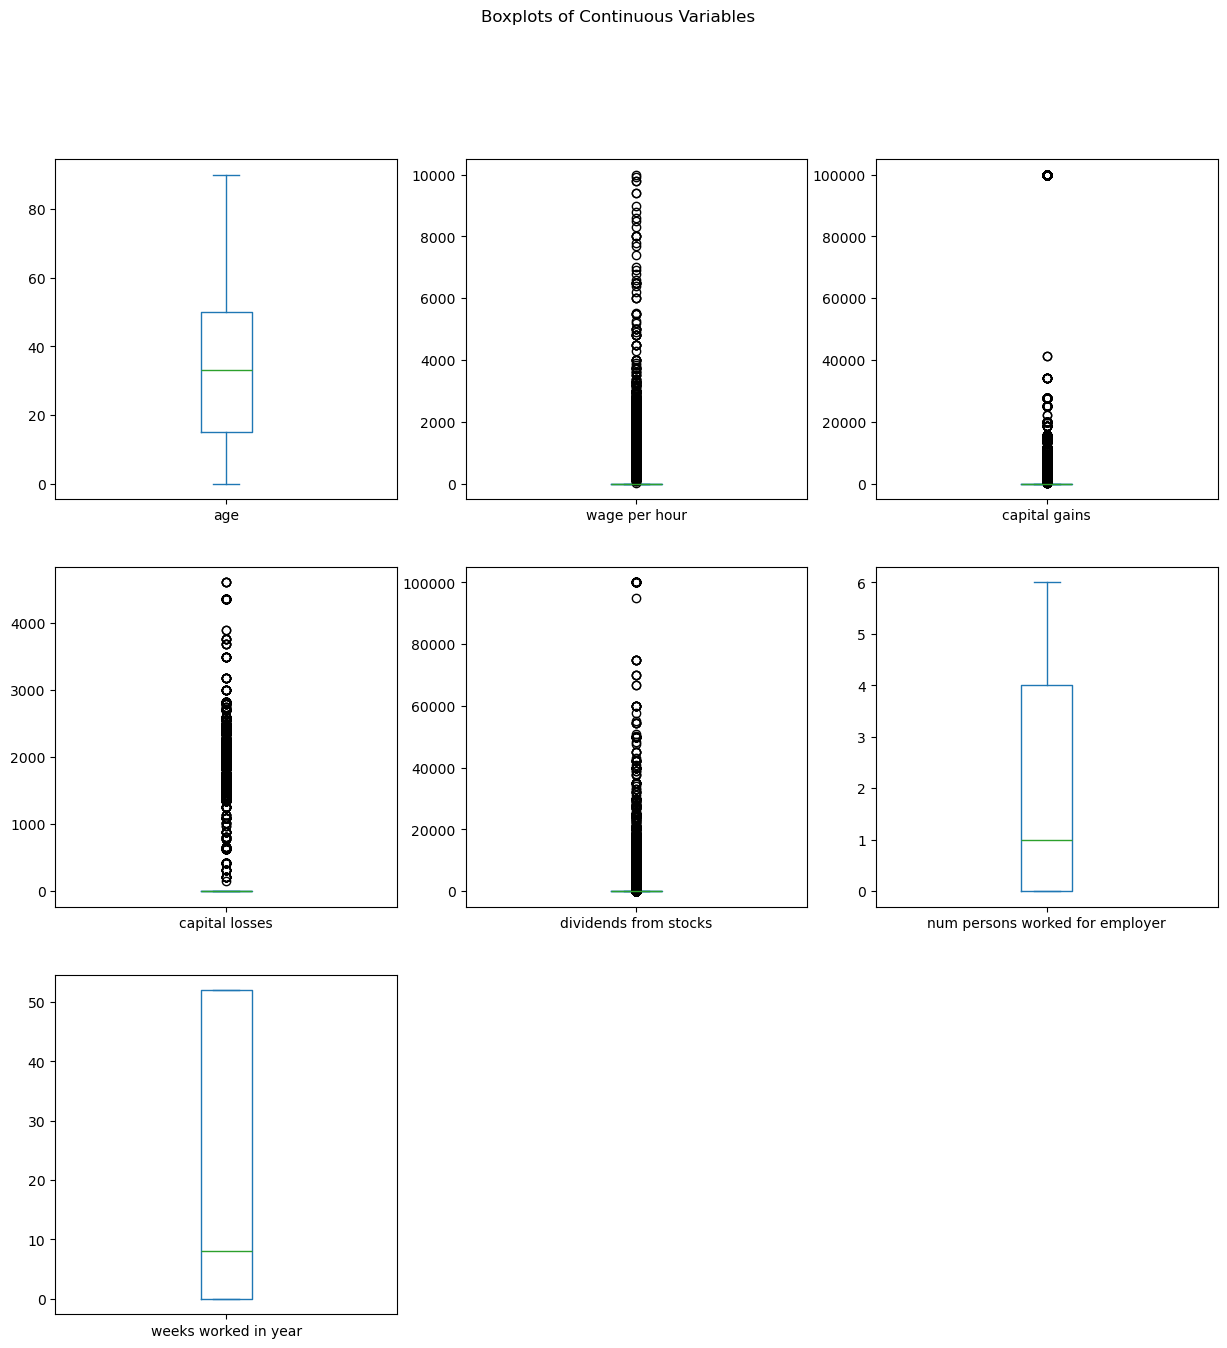

In [255]:
df[continuous_vars].plot(kind='box', subplots=True, layout=(len(continuous_vars) // 3 + 1, 3),
                         figsize=(15, 5 * (len(continuous_vars) // 3 + 1)), sharex=False, sharey=False)
plt.suptitle("Boxplots of Continuous Variables")
plt.show()

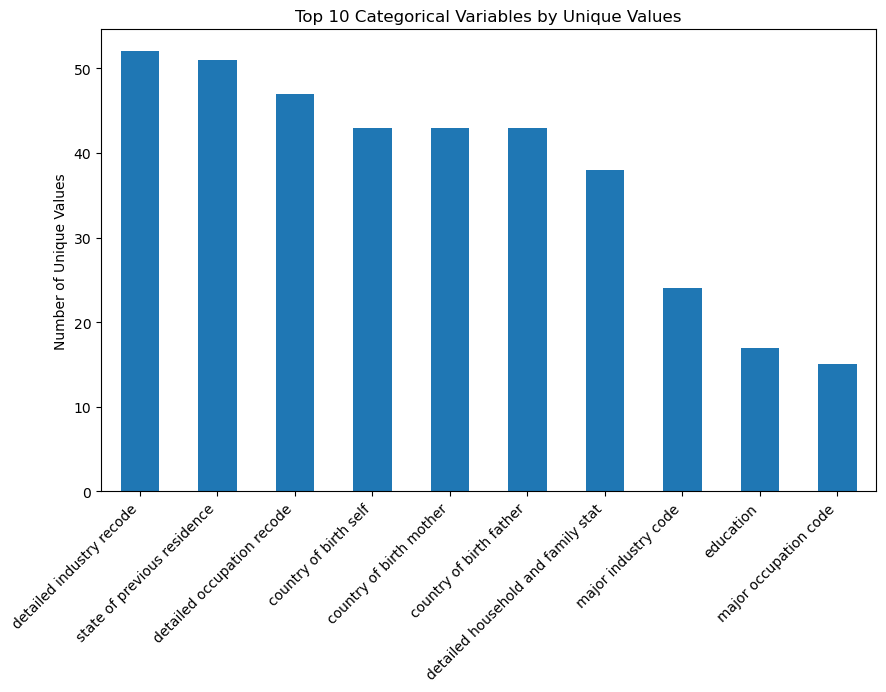

detailed industry recode              52
state of previous residence           51
detailed occupation recode            47
country of birth self                 43
country of birth mother               43
country of birth father               43
detailed household and family stat    38
major industry code                   24
education                             17
major occupation code                 15
dtype: int64

In [256]:
# Take top 10
top10_unique = unique_counts.head(10)

# Plot
plt.figure(figsize=(10, 6))
top10_unique.plot(kind="bar")
plt.ylabel("Number of Unique Values")
plt.title("Top 10 Categorical Variables by Unique Values")
plt.xticks(rotation=45, ha="right")
plt.show()

top10_unique

In [257]:
#check typos
#for col in categorical_vars:
    #print(f"\nColumn: {col}")
    #count unique numbers
    #print(f"Number of unique values: {df[col].nunique()}")
    #count 
    #print("Unique values (sample):", df[col].unique())

# Count unique values for categorical variables
#unique_counts = df[categorical_vars].nunique().sort_values(ascending=False)

In [258]:
df = df.replace('?', np.nan)

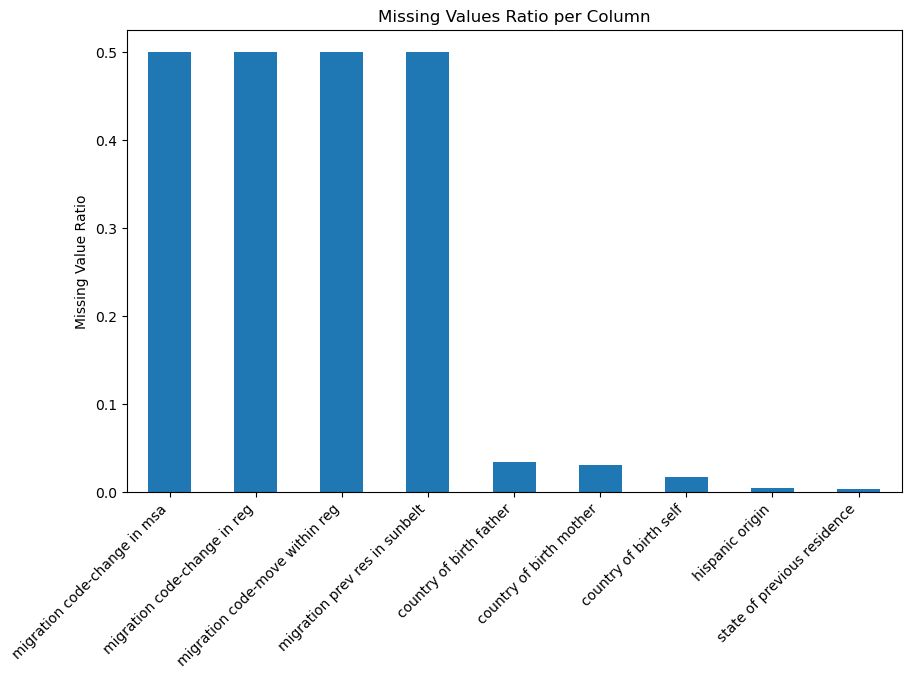

In [259]:
data_missing_rate = df.isna().mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
missing_ratio.sort_values(ascending=False).plot(kind="bar")
plt.ylabel("Missing Value Ratio")
plt.title("Missing Values Ratio per Column")
plt.xticks(rotation=45, ha="right")
plt.show()

In [260]:
df = df.fillna("unknown")
df["label"] = df["label"].replace({"- 50000.": 0,"50000+.": 1})

# Count label values
label_counts = df['label'].value_counts()
label_counts

/var/folders/83/1tl03rmj4w18fl3qjzcq2py80000gn/T/ipykernel_66940/517902172.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna("unknown")
/var/folders/83/1tl03rmj4w18fl3qjzcq2py80000gn/T/ipykernel_66940/517902172.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["label"] = df["label"].replace({"- 50000.": 0,"50000+.": 1})


label
0    187141
1     12382
Name: count, dtype: int64

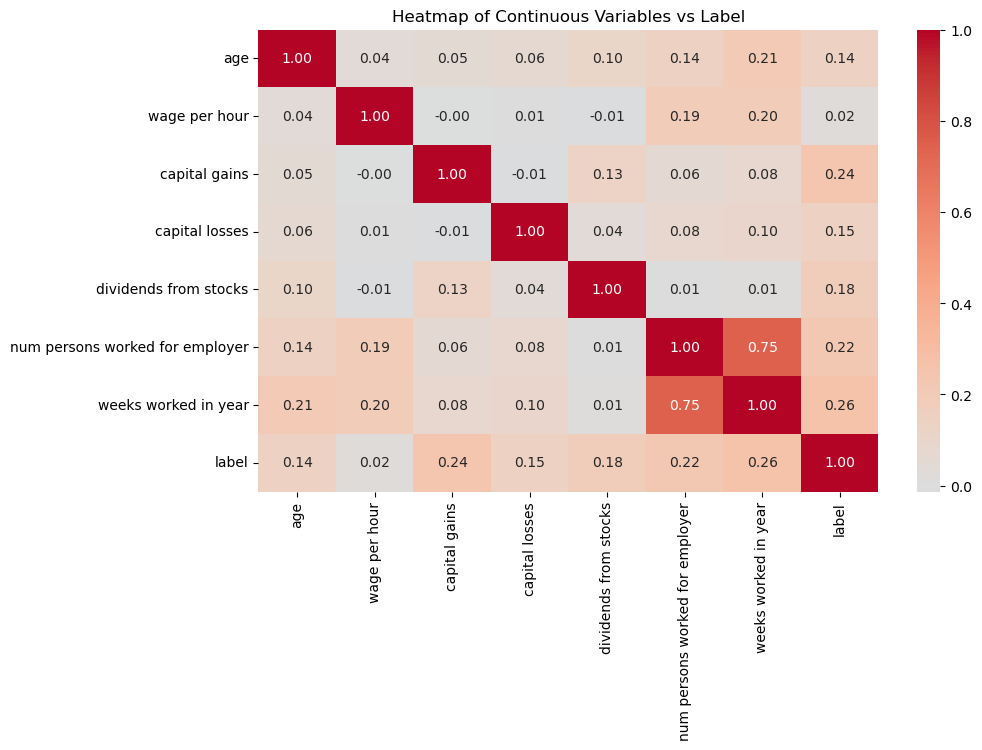

,age,wage per hour,capital gains,capital losses,dividends from stocks,num persons worked for employer,weeks worked in year,label
age,1.000000,0.036938,0.053590,0.063351,0.104976,0.140887,0.206181,0.135720
wage per hour,0.036938,1.000000,-0.001082,0.010993,-0.005731,0.191543,0.195687,0.024528
capital gains,0.053590,-0.001082,1.000000,-0.012700,0.131476,0.058015,0.083549,0.240725
capital losses,0.063351,0.010993,-0.012700,1.000000,0.042427,0.084255,0.100762,0.147417
dividends from stocks,0.104976,-0.005731,0.131476,0.042427,1.000000,0.007206,0.013823,0.175779
num persons worked for employer,0.140887,0.191543,0.058015,0.084255,0.007206,1.000000,0.747302,0.222684
weeks worked in year,0.206181,0.195687,0.083549,0.100762,0.013823,0.747302,1.000000,0.262316
label,0.135720,0.024528,0.240725,0.147417,0.175779,0.222684,0.262316,1.000000


In [261]:
# Calculate correlation matrix for continuous variables + label
corr_matrix = df[continuous_vars + ['label']].corr()

# Plot heatmap of correlations with label
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, fmt=".2f",
            annot=True, cmap='coolwarm', center=0)
plt.title("Heatmap of Continuous Variables vs Label")
plt.show()
corr_matrix

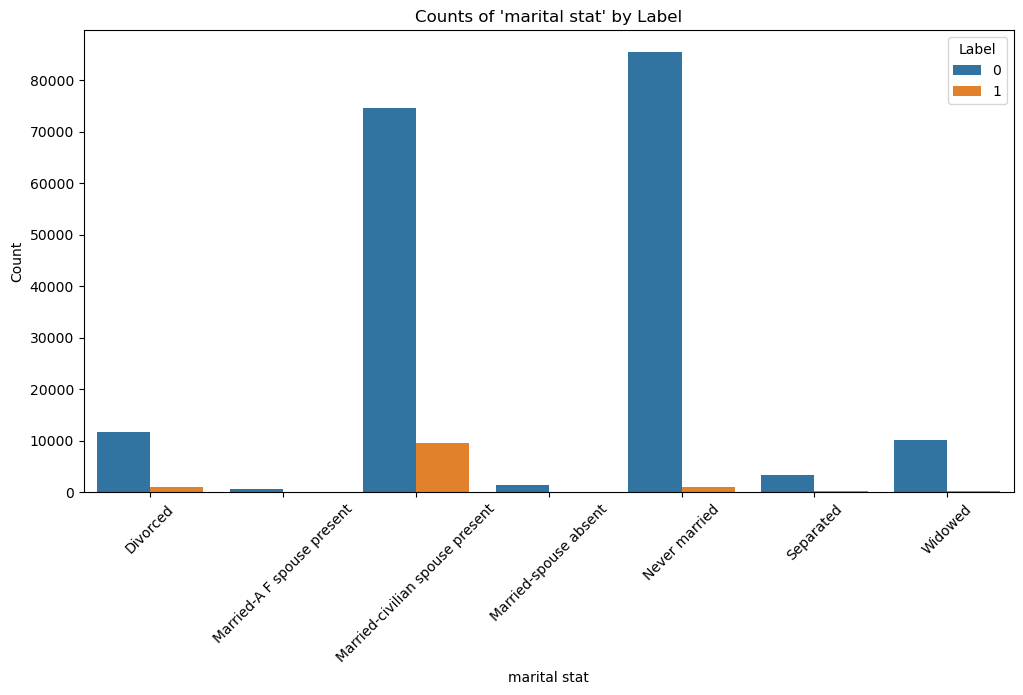

In [262]:
col = "marital stat"

count_df = df.groupby([col, 'label']).size().reset_index(name='count')
#print(count_df)

plt.figure(figsize=(12, 6))
sns.barplot(data=count_df, x=col, y='count', hue='label')
plt.title(f"Counts of '{col}' by Label")
plt.ylabel("Count")
plt.xlabel(col)
plt.xticks(rotation=45)
plt.legend(title="Label")
plt.show()

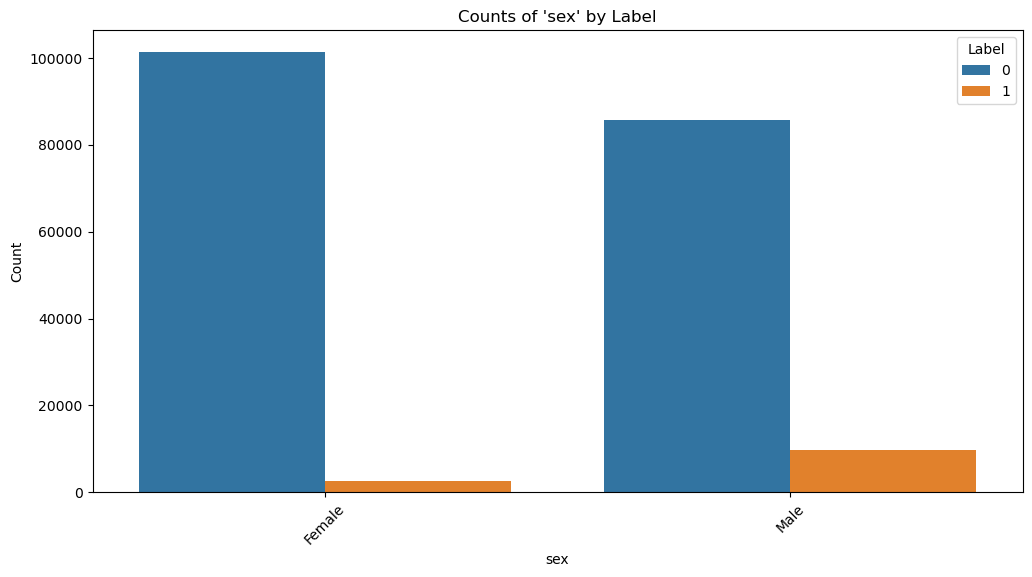

In [263]:
col = "sex"

count_df = df.groupby([col, 'label']).size().reset_index(name='count')
#print(count_df)

plt.figure(figsize=(12, 6))
sns.barplot(data=count_df, x=col, y='count', hue='label')
plt.title(f"Counts of '{col}' by Label")
plt.ylabel("Count")
plt.xlabel(col)
plt.xticks(rotation=45)
plt.legend(title="Label")
plt.show()

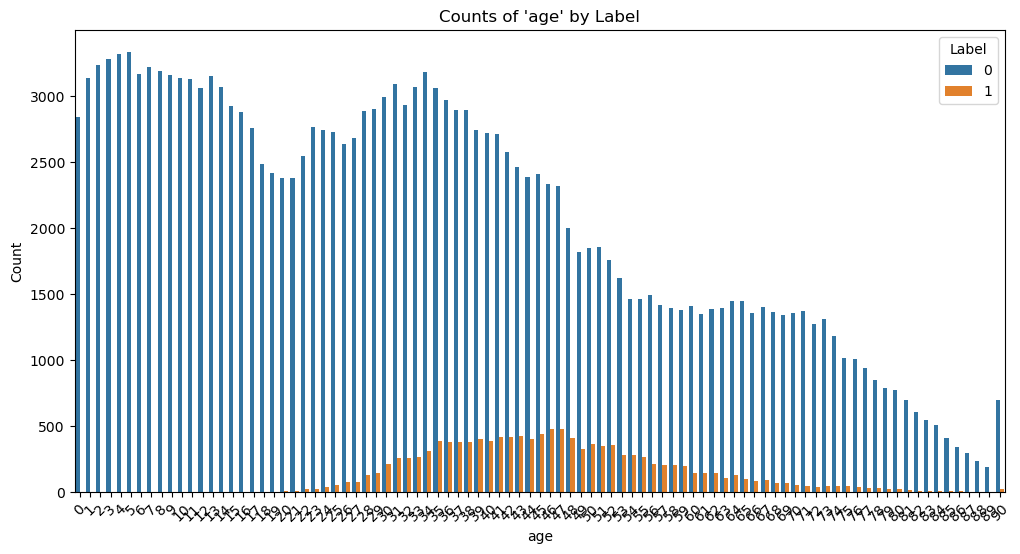

In [264]:
col = "age"

count_df = df.groupby([col, 'label']).size().reset_index(name='count')
#print(count_df)

plt.figure(figsize=(12, 6))
sns.barplot(data=count_df, x=col, y='count', hue='label')
plt.title(f"Counts of '{col}' by Label")
plt.ylabel("Count")
plt.xlabel(col)
plt.xticks(rotation=45)
plt.legend(title="Label")
plt.show()

In [265]:
#processing data 
categorical_vars.remove('label')

X_cat = df[categorical_vars]
X_cont = df[continuous_vars]

# One-hot encoding
X_cat_encoded = pd.get_dummies(X_cat, drop_first=False)
X = pd.concat([X_cont, X_cat_encoded], axis=1)

y = df['label']

X.shape

(199523, 408)

In [266]:
#get x and y for the model
X_cat_encoded = pd.get_dummies(df[categorical_vars], drop_first=False)
X = pd.concat([df[continuous_vars], X_cat_encoded], axis=1)
y = df['label']

In [267]:
corr_with_label = X.copy()
corr_with_label['label'] = y
corr_values = corr_with_label.corr()['label'].drop('label')
corr_values = corr_values.abs().sort_values(ascending=False) 
corr_values[:10]

weeks worked in year                                    0.262316
major occupation code_Executive admin and managerial    0.241584
capital gains                                           0.240725
num persons worked for employer                         0.222684
major occupation code_Not in universe                   0.221969
major industry code_Not in universe or children         0.221969
class of worker_Not in universe                         0.220914
detailed household and family stat_Householder          0.213482
detailed household summary in household_Householder     0.212778
major occupation code_Professional specialty            0.212686
Name: label, dtype: float64

In [ ]:
## training data 

In [270]:
X_temp, X_holdout, y_temp, y_holdout = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y_temp,  
    test_size=0.20,  
    random_state=42, 
    stratify=y_temp  
)

#get weight - only in training data!
sample_weights_train = df.loc[X_train.index, 'weight']

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of y_holdout:", y_holdout.shape)
print("Shape of y_tholdout:", y_holdout.shape)
print("Shape of sample_weights_train:", len(sample_weights_train))

Shape of X_train: (127694, 408)
Shape of X_test: (31924, 408)
Shape of y_train: (127694,)
Shape of y_test: (31924,)
Shape of y_holdout: (39905,)
Shape of y_tholdout: (39905,)
Shape of sample_weights_train: 127694


Best K=31, mean F1=0.4144
1-SE  K=31, mean F1=0.4144
Selected 31 features.


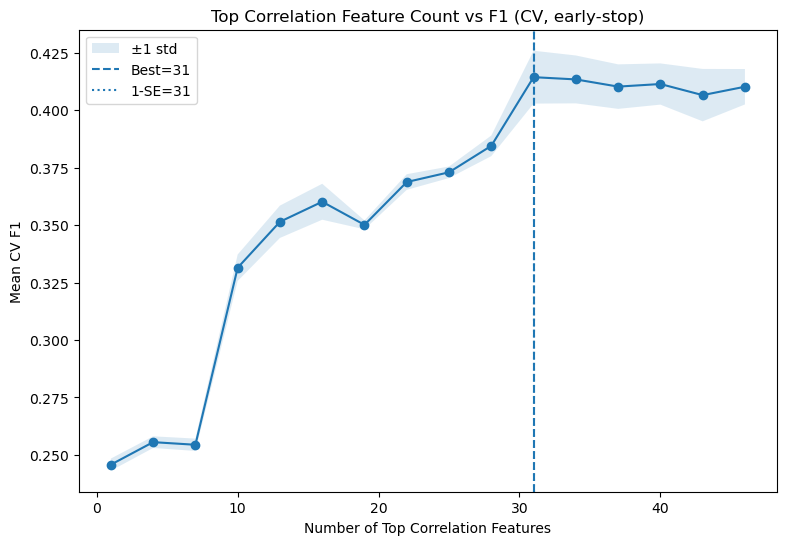

In [272]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

ranked_feats = corr_values.index.tolist()
max_features = len(ranked_feats)
feature_nums = list(range(1, max_features + 1, 3)) 

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#just do a rough selection here
model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

tol = 0.001     
patience = 5
no_improve = 0
best_so_far = -np.inf

f1_means, f1_stds, ks_done = [], [], []

for n in feature_nums:
    cols = ranked_feats[:n]
    scores = cross_val_score(model, X_train[cols], y_train, cv=cv, scoring='f1', n_jobs=-1)
    m, s = scores.mean(), scores.std()

    f1_means.append(m)
    f1_stds.append(s)
    ks_done.append(n)

    if m > best_so_far + tol:
        best_so_far = m
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            break  # early stop

f1_means = np.array(f1_means)
f1_stds  = np.array(f1_stds)

best_idx = int(np.argmax(f1_means))
k_best   = ks_done[best_idx]
f1_best  = f1_means[best_idx]

se_best  = f1_stds[best_idx] / np.sqrt(cv.get_n_splits())

k_1se = next(k for k, m in zip(ks_done, f1_means) if m >= f1_best - se_best)

selected_features = ranked_feats[:k_1se] 

print(f"Best K={k_best}, mean F1={f1_best:.4f}")
print(f"1-SE  K={k_1se}, mean F1={f1_means[ks_done.index(k_1se)]:.4f}")
print(f"Selected {len(selected_features)} features.")


plt.figure(figsize=(9,6))
plt.plot(ks_done, f1_means, marker='o')
plt.fill_between(ks_done, f1_means - f1_stds, f1_means + f1_stds, alpha=0.15, label='±1 std')
plt.axvline(k_best, linestyle='--', label=f'Best={k_best}')
plt.axvline(k_1se, linestyle=':',  label=f'1-SE={k_1se}')
plt.xlabel("Number of Top Correlation Features")
plt.ylabel("Mean CV F1")
plt.title("Top Correlation Feature Count vs F1 (CV, early-stop)")
plt.legend()
plt.show()


In [273]:
#due to the heavily imbalance data - we will built the class_weight based on the data 
train_classweight_df = df.loc[X_train.index, ['weight', 'label']].copy()
w_pos = train_classweight_df['weight'][train_classweight_df['label']==1].sum()
w_neg = train_classweight_df['weight'][train_classweight_df['label']==0].sum()
cw = {0: 0.5*(w_pos+w_neg)/w_neg, 1: 0.5*(w_pos+w_neg)/w_pos}
cw

{0: 0.5341159123668836, 1: 7.8279587927032885}

In [274]:
param_grid_lr = {'C': [0.01, 0.1], 'solver': ['liblinear', 'lbfgs']}
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 20], 'min_samples_split': [2, 5]}
param_grid_dt = {'max_depth': [10, 20, 30], 'min_samples_split': [2, 5]}

# define model
models = {
    'Logistic Regression': LogisticRegression(class_weight=cw),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight=cw),
    'Decision Tree': DecisionTreeClassifier(class_weight=cw)
}

param_grids = {
    'Logistic Regression': param_grid_lr,
    'Random Forest': param_grid_rf,
    'Decision Tree': param_grid_dt
}

# train 
best_models = {}
best_params = {}

for model_name, model in models.items():
    print(f"\n Training {model_name}...")
    
    grid_search = GridSearchCV(
        model, 
        param_grids[model_name], 
        cv=5, 
        n_jobs=-1,
        scoring='f1'
    )
    
    # get sample_weight when fitting
    grid_search.fit(X_train, y_train, sample_weight=sample_weights_train)
    
    best_models[model_name] = grid_search.best_estimator_
    best_params[model_name] = grid_search.best_params_
    
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")


 Training Logistic Regression...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Best parameters for Logistic Regression: {'C': 0.1, 'solver': 'liblinear'}
Best cross-validation score: 0.4254

 Training Random Forest...
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation score: 0.4755

 Training Decision Tree...
Best parameters for Decision Tree: {'max_depth': 30, 'min_samples_split': 2}
Best cross-validation score: 0.4628


In [275]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


def plot_roc_curve(y_true, y_prob, model_name, class_label=0):

    fpr, tpr, _ = roc_curve(y_true == class_label, y_prob[:, class_label])
    roc_auc = roc_auc_score(y_true == class_label, y_prob[:, class_label])

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Class {class_label} - {model_name}')
    plt.legend(loc='lower right')
    plt.show()



for model_name, model in best_models.items():
    print(f"\nEvaluating {model_name}:")


    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)


    print(classification_report(y_test, y_pred))
    #print(f1_score(y_test, y_pred))


    #plot_confusion_matrix(y_test, y_pred, model_name)
    #plot_roc_curve(y_test, y_prob, model_name, class_label=0)


Evaluating Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91     29943
           1       0.28      0.89      0.43      1981

    accuracy                           0.85     31924
   macro avg       0.64      0.87      0.67     31924
weighted avg       0.95      0.85      0.88     31924


Evaluating Random Forest:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     29943
           1       0.34      0.82      0.48      1981

    accuracy                           0.89     31924
   macro avg       0.66      0.86      0.71     31924
weighted avg       0.95      0.89      0.91     31924


Evaluating Decision Tree:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95     29943
           1       0.39      0.61      0.47      1981

    accuracy                           0.92     31924
   macro avg       0.68      0.77      0.

In [276]:
#evluate on the holdout data 
for model_name, model in best_models.items():
    print(f"\nEvaluating {model_name}:")


    y_pred = model.predict(X_holdout)
    y_prob = model.predict_proba(X_holdout)


    print(classification_report(y_holdout, y_pred))
    #print(f1_score(y_holdout, y_pred))


Evaluating Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.85      0.92     37429
           1       0.28      0.89      0.43      2476

    accuracy                           0.85     39905
   macro avg       0.64      0.87      0.67     39905
weighted avg       0.95      0.85      0.89     39905


Evaluating Random Forest:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     37429
           1       0.33      0.81      0.47      2476

    accuracy                           0.89     39905
   macro avg       0.66      0.85      0.70     39905
weighted avg       0.95      0.89      0.91     39905


Evaluating Decision Tree:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     37429
           1       0.38      0.62      0.48      2476

    accuracy                           0.91     39905
   macro avg       0.68      0.78      0.

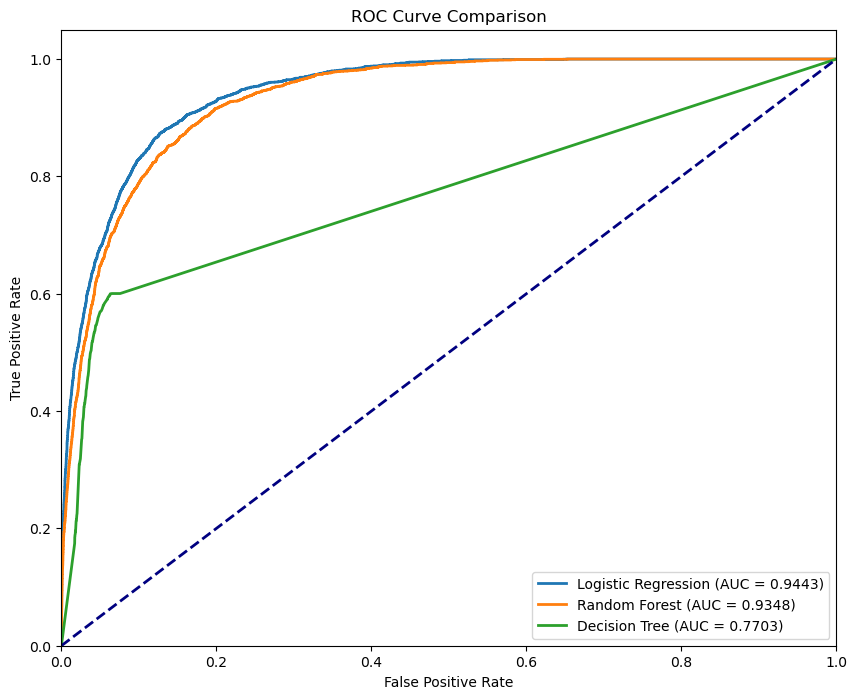

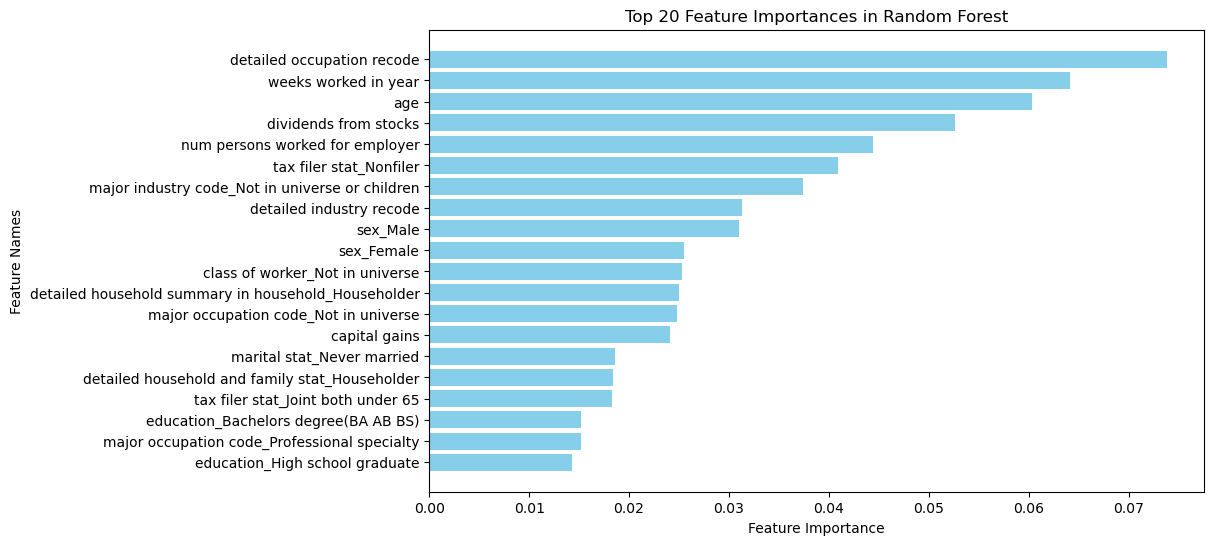

(array([0.07388628, 0.06415413, 0.06035844, 0.05264574, 0.04446338,
        0.04094365, 0.03740001, 0.03129841, 0.03104056, 0.02549728,
        0.02528957, 0.02496813, 0.02483691, 0.02404922, 0.01856384,
        0.01837541, 0.01826337, 0.01521756, 0.0151819 , 0.01426399]),
 ['detailed occupation recode',
  'weeks worked in year',
  'age',
  'dividends from stocks',
  'num persons worked for employer',
  'tax filer stat_Nonfiler',
  'major industry code_Not in universe or children',
  'detailed industry recode',
  'sex_Male',
  'sex_Female',
  'class of worker_Not in universe',
  'detailed household summary in household_Householder',
  'major occupation code_Not in universe',
  'capital gains',
  'marital stat_Never married',
  'detailed household and family stat_Householder',
  'tax filer stat_Joint both under 65',
  'education_Bachelors degree(BA AB BS)',
  'major occupation code_Professional specialty',
  'education_High school graduate'])

In [246]:
def plot_roc_comparison(models, X_test, y_test, class_label=0):
    plt.figure(figsize=(10, 8))

    for model_name, model in models.items():

        y_prob = model.predict_proba(X_test)  # shape: (n_samples, n_classes)


        fpr, tpr, _ = roc_curve(y_test == class_label, y_prob[:, class_label])


        roc_auc = roc_auc_score(y_test == class_label, y_prob[:, class_label])


        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.4f})')


    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')


    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve Comparison')
    plt.legend(loc='lower right')
    plt.show()


plot_roc_comparison(best_models, X_test, y_test, class_label=1)


rf_model = best_models['Random Forest']

feature_importances = rf_model.feature_importances_

feature_names = X_train.columns

sorted_idx = np.argsort(feature_importances)[::-1]

top_n = 20
top_features = [feature_names[i] for i in sorted_idx[:top_n]]
top_importances = feature_importances[sorted_idx[:top_n]]

plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.title("Top 20 Feature Importances in Random Forest")
plt.gca().invert_yaxis()
plt.show()

top_importances, top_features